In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import requests
import time
import io
import json
import re
import sys
from tqdm import tqdm
from time import sleep

## 1. Counter id and token initialization:

Enter "id_app" for your Yandex Metrika counter. You can find it in your Yandex.Metrika account:
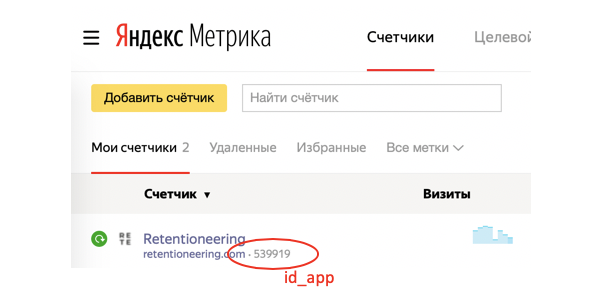

In [2]:
id_app = 5239

To access Yandex Metrika API you'll need to obtain authorization token. Here is the detailed instructions:

https://yandex.ru/dev/oauth/doc/dg/tasks/get-oauth-token-docpage/

In [3]:
token_m = 'ABDFMLDFLgMdDFJLKYJ1Ed94jiwrg87SBDoJYCHeWQaE0'

header = {'Authorization': 'OAuth {token}'.format(token=token_m)}
ids = {
    'Counter': id_app,
}

### View request buffer (optional)

Yandex Metrika keeps your request for some time after initiation. You can view your buffer using the script below. 

In [ ]:
payload = {
    'fields': 'ym:pv:dateTime,ym:pv:watchID',
    'date1': '2019-11-01',
    'date2': '2019-11-02',
    'source': 'hits' # another option is 'visits'
}

i = 1
for key, value in ids.items():
    payload['ids'] = value
    r = requests.get('https://api-metrika.yandex.net/management/v1/counter/{id_app}/logrequests'.format(id_app=id_app),
                     params=payload,
                     headers=header)
    data = str(r.json()).split(",")
    i += 1
    payload['ids'] = value
    print('total', key, data)

###  Clear request buffer (optional)

The size of the buffer is limited and too many requests stored in the buffer can prevent you from importing new data. In this case you have to clean your request buffer

In [11]:
request_id_list = [int(x.split(':')[1].strip()) for x in data[1:] if "'request_id':" in x]

for request_id in request_id_list: 
    p = requests.post('https://api-metrika.yandex.net/management/v1/counter/{id_app}/logrequest/{request_id}/clean?"'\
                      .format(id_app=id_app, request_id=request_id), headers=header).content
    print(p)
    sleep(2)

## 2. Data import from Yandex Metrika:

Basic information about hits and visits in Yandex Metrika:

In [4]:
def get_results(payload, id_app):
    print('It may take a while')
    p = requests.post('https://api-metrika.yandex.net/management/v1/counter/{id_app}/logrequests'\
                      .format(id_app=id_app), params=payload, headers=header).content
    print(p, end = '\r')
    request_id = json.load(io.StringIO(p.decode('utf-8')))['log_request']['request_id']
    idx = 1
    while True:
        print(f"Query: {idx}")
        r = requests.get('https://api-metrika.yandex.net/management/v1/counter/{id_app}/logrequest/{request_id}/part/0/download'.format(id_app=id_app, request_id=request_id), headers=header).content
        if pd.read_csv(io.StringIO(r.decode('utf-8')), sep='\t').shape[0] == 0:
            idx += 1
            sleep(60)
        else:
            break
    data = pd.read_csv(io.StringIO(r.decode('utf-8')), sep='\t')
    return data



### import "visits":

list of availbale fields to import:

https://yandex.ru/dev/metrika/doc/api2/logs/fields/visits-docpage/

In [ ]:
payload = {
    'fields': 'ym:s:dateTime,ym:s:clientID,ym:s:isNewUser,ym:s:visitID,ym:s:lastTrafficSource',
    'date1': '2019-12-01',
    'date2': '2019-12-02',
    'source': 'visits' 
}

visits_data = get_results(payload, id_app)

In [6]:
visits_data.shape

(71692, 5)

#### save visits data to file:

In [10]:
visits_data.to_csv('visits_1201_1215.csv.gz', compression='gzip', index_label=False)

### import hits:

List of availbale fields to import:

https://yandex.ru/dev/metrika/doc/api2/logs/fields/hits-docpage/

In [ ]:
payload = {
    'fields': 'ym:pv:dateTime,ym:pv:URL,ym:pv:clientID,ym:pv:deviceCategory,ym:pv:title,ym:pv:referer,ym:pv:from,ym:pv:params,ym:pv:lastTrafficSource,ym:pv:artificial,ym:pv:goalsID',
    'date1': '2019-12-01',
    'date2': '2019-12-02',
    'source': 'hits' # another option is 'visits'
}

hits_data = get_results(payload, id_app)

#### save hits data to file:

In [ ]:
hits_data.to_csv('hits_1115_1215.csv.gz', compression='gzip', index_label=False)

# 3. Cyclic exporter for large datasets (optional)

Some datasets may be too large to import using single import query. In this case one solution can be to import data in small batches and then concatinate datasets in a single dataframe.

In [ ]:
date_start = '2019-11-14'
total_cycles = 4
step_size = 1 #in days

res = []
for cnt in tqdm(range(total_cycles)):
    payload = {
        'fields': 'ym:s:dateTime,ym:s:clientID,ym:s:isNewUser,ym:s:visitID,ym:s:lastTrafficSource',
        'date1': (pd.to_datetime(date_start)+pd.Timedelta(days=cnt)).strftime('%Y-%m-%d'),
        'date2': (pd.to_datetime(date_start)+pd.Timedelta(days=cnt+step_size)).strftime('%Y-%m-%d'),
        'source': 'visits' # another option is 'visits'
    }


    hits_data_raw = get_results(payload, id_app)
    res.append(hits_data_raw)

In [14]:
df_visits = pd.concat(res)
df_visits.shape

(156913, 5)

#### Save imported data to file:

In [11]:
df_visits.reset_index(inplace=True)
df_visits.to_csv('visits_1115_1215.csv.gz', compression='gzip', index_label=False)